In [36]:
# for data processing
import pandas as pd
import numpy as np

# for plotting
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# for displaying Pearsons correlation and o value on joint plot
import scipy.stats as stats  

import plotly.io as pio
pio.templates.default = "plotly_dark"
pd.set_option('display.max_rows', 200)

In [37]:
data = pd.read_csv('Forest_type(train).csv')
data.drop('Id',axis=1, inplace=True)
pd.set_option('display.max_columns',None)


In [38]:
data.head()
data.shape

(15120, 55)

# 1. Data Cleaning

In [39]:
# finding the continuous and categorical features

for column in data.columns:
    unique_values = np.unique(data[column].values)
    if len(unique_values) > 10:
        print(column,'-',"Continuous")
    else:
         print(column,'-',"Categorical")

Elevation - Continuous
Aspect - Continuous
Slope - Continuous
Horizontal_Distance_To_Hydrology - Continuous
Vertical_Distance_To_Hydrology - Continuous
Horizontal_Distance_To_Roadways - Continuous
Hillshade_9am - Continuous
Hillshade_Noon - Continuous
Hillshade_3pm - Continuous
Horizontal_Distance_To_Fire_Points - Continuous
Wilderness_Area1 - Categorical
Wilderness_Area2 - Categorical
Wilderness_Area3 - Categorical
Wilderness_Area4 - Categorical
Soil_Type1 - Categorical
Soil_Type2 - Categorical
Soil_Type3 - Categorical
Soil_Type4 - Categorical
Soil_Type5 - Categorical
Soil_Type6 - Categorical
Soil_Type7 - Categorical
Soil_Type8 - Categorical
Soil_Type9 - Categorical
Soil_Type10 - Categorical
Soil_Type11 - Categorical
Soil_Type12 - Categorical
Soil_Type13 - Categorical
Soil_Type14 - Categorical
Soil_Type15 - Categorical
Soil_Type16 - Categorical
Soil_Type17 - Categorical
Soil_Type18 - Categorical
Soil_Type19 - Categorical
Soil_Type20 - Categorical
Soil_Type21 - Categorical
Soil_Type22 

In [40]:
def outlier_detection(df, column):  # finding extreme outlier (meaning instead of 1.5 we used 3)
    first_quartile = np.percentile(df[column].values, 25)
    third_quartile =  np.percentile(df[column].values, 75)
    IQR = third_quartile - first_quartile
    
    upper_limit = third_quartile + 3 * (IQR)
    lower_limit = first_quartile - 3 * (IQR)
    
    outlier_count = 0
    for value in df[column].tolist():
        if(value < lower_limit) | (value > upper_limit):
            outlier_count+=1
    return lower_limit, upper_limit, outlier_count


for column in data.columns.tolist():
    if outlier_detection(data, column)[2] > 0:
        print("There are {} outlier in {} ".format( outlier_detection(data, column)[2], column))
        


There are 53 outlier in Horizontal_Distance_To_Hydrology 
There are 49 outlier in Vertical_Distance_To_Hydrology 
There are 3 outlier in Horizontal_Distance_To_Roadways 
There are 7 outlier in Hillshade_9am 
There are 20 outlier in Hillshade_Noon 
There are 132 outlier in Horizontal_Distance_To_Fire_Points 
There are 3597 outlier in Wilderness_Area1 
There are 499 outlier in Wilderness_Area2 
There are 355 outlier in Soil_Type1 
There are 623 outlier in Soil_Type2 
There are 962 outlier in Soil_Type3 
There are 843 outlier in Soil_Type4 
There are 165 outlier in Soil_Type5 
There are 650 outlier in Soil_Type6 
There are 1 outlier in Soil_Type8 
There are 10 outlier in Soil_Type9 
There are 2142 outlier in Soil_Type10 
There are 406 outlier in Soil_Type11 
There are 227 outlier in Soil_Type12 
There are 476 outlier in Soil_Type13 
There are 169 outlier in Soil_Type14 
There are 114 outlier in Soil_Type16 
There are 612 outlier in Soil_Type17 
There are 60 outlier in Soil_Type18 
There a

I am not going to consider other columns for potential outlier elimination because their data range is already fixed between 0 and 255 (e.g. Hillsahde columns) or they seem like one-hot-encoded columns (e.g. Soil type and Wilderness areas)

lets take a closer look at :
    1. Horizontal_Distance_To_Hydrology -53
    2. Vertical_Distance_To_Hydrology - 49
    3. Horizontal_Distance_To_Roadways - 3
    4. Horizontal_Distance_To_Fire_Points -132

Recall the data ranges of those 4 columns:

1. Horizontal_Distance_To_Hydrology: 0, 1343
2. Vertical_Distance_To_Hydrology: -146, 554
3. Horizontal_Distance_To_Roadways: 0, 6890
4. Horizaontal_Distance_To_Firepoints: 0, 6993

Considering the Horizaontal_Distance_To_Firepoints having the highest number of outliers and widest data range, I am going to remove outliers only from that column

In [41]:
data = data[(data['Horizontal_Distance_To_Fire_Points'] > outlier_detection(data, 'Horizontal_Distance_To_Fire_Points')[0]) &
              (data['Horizontal_Distance_To_Fire_Points'] < outlier_detection(data, 'Horizontal_Distance_To_Fire_Points')[1])]


   

    

In [42]:
forest = data.copy() # will use forest name for EDA 

In [43]:

# renaming Wilderness area column into actual column
forest = forest.rename(columns={"Wilderness_Area1":"Rawah_WA", "Wilderness_Area2":"Neota_WA",
                                "Wilderness_Area3":"Comanche_Peak_WA","Wilderness_Area4":"Cache_la_Poudre_WA",
                                "Horizontal_Distance_To_Hydrology":"HD_Hydrology",
                                "Vertical_Distance_To_Hydrology":"VD_Hydrology",
                                "Horizontal_Distance_To_Roadways":"HD_Roadways",
                               "Horizontal_Distance_To_Fire_Points":"HD_Fire_Points"})


# Combining Soil_types columns and Wilderness_area columns

# Here I have converted the encoded values for columns Wilderness_Areas 
#and Soil_types back to a single column for better analysis.
forest['Wild_Areas'] = (forest.iloc[:,10:14] == 1).idxmax(1)
forest['Soil_Types'] = (forest.iloc[:, 14:55] == 1).idxmax(1)

#Drop the columns which are not required now

forest = forest.drop(columns=['Rawah_WA', 'Neota_WA', 'Comanche_Peak_WA',
                               'Cache_la_Poudre_WA', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
                               'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
                               'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
                               'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
                               'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
                               'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
                               'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
                               'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
                               'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
                               'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'])


# renaming covertype column
forest['Cover_Type'].replace({1:'Spruce/Fir', 2:'Lodgepole Pine', 3:'Ponderosa Pine'
                              , 4:'Cottonwood/Willow', 5:'Aspen', 6:'Douglas-fir', 7:'Krummholz'}, inplace=True)
   
        


In [44]:

# lets replace the name Soli_Type with ST


lst = []
for value in forest['Soil_Types']:
    value = value.replace('Soil_Type',"ST")
    lst.append(value)
    
forest['Soil_Types'] = lst 

In [45]:
forest.head()

Elevation  Aspect  Slope  HD_Hydrology  VD_Hydrology  HD_Roadways  \
11       2886     151     11           371            26         5253   
14       2503     157      4            67             4          674   
15       2495      51      7            42             2          752   
17       2517      72      7            85             6          595   
18       2504       0      4            95             5          691   

    Hillshade_9am  Hillshade_Noon  Hillshade_3pm  HD_Fire_Points  \
11            234             240            136            4051   
14            224             240            151            5600   
15            224             225            137            5576   
17            228             227            133            5607   
18            214             232            156            5572   

        Cover_Type Wild_Areas Soil_Types  
11  Lodgepole Pine   Rawah_WA       ST30  
14           Aspen   Rawah_WA       ST18  
15           Aspen   Rawah_WA       ST16  
17           Aspen   Rawah_WA       ST18  
18           Aspen   Rawah_WA       ST18

## Findings from Data cleaning:

Training dataset (trees dataframe) has 15120 entries and 56 columns with headers appropriately named. Dataset is clean and well-formatted, meaning it had no NA values and every column has a numeric (float or integer) data type.

4 columns had outliers, outliers of the Horizontal_Distance_To_Fire_Points is removed considering this column has a wider range and has the most number of outliers.

Cover_Type is our label/target column. Wilderness_Area and Soil_Type columns might have binary values (0,1) if so, they are the one-hot-encoded columns of 4 wilderness areas and 40 soil types respectively. I am going to start exploratory data analysis by seeking answer to that suspicion.

# 2. Exploratory Data Analysis

## 2.1 Univariate Analysis

### Elevation

Elevation of geographic location is its height above or below a fixed reference point , commonly (sea level)

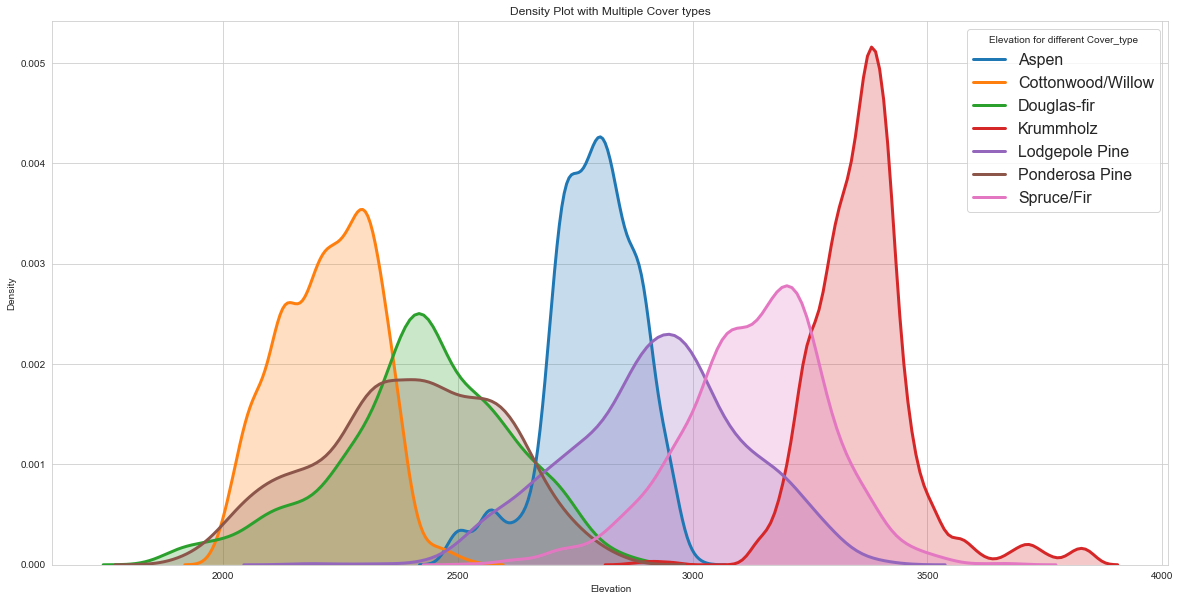

In [46]:


figure = plt.figure(figsize=(20,10))
cover_types = np.unique(forest['Cover_Type'].values)
for cover in cover_types:
    subset = forest[forest['Cover_Type'] == cover]
    
    sns.distplot(subset['Elevation'], kde=True,hist=False,  label=cover, kde_kws = {'shade':True, 'linewidth': 3},)
    
plt.legend(prop={'size': 16}, title = 'Elevation for different Cover_type')
plt.title('Density Plot with Multiple Cover types')
plt.xlabel('Elevation')
plt.ylabel('Density');

#or
# sns.FacetGrid(forest, hue='Cover_Type', aspect=4.75).map(sns.distplot, 'Elevation')\
#                 .add_legend()

# plt.show()



In [47]:
temp = forest.groupby(['Cover_Type'], as_index=False)[['Elevation']].median()
temp.sort_values('Elevation', ascending=False).style.background_gradient(cmap='Reds')

All the Forest cover types are highly distributed. The above plot shows us that Cottonwood tress grow at a lower elevated regions compared to Krummholz, Spruce and Lodgepole tress grow at higher elevation

### Slope

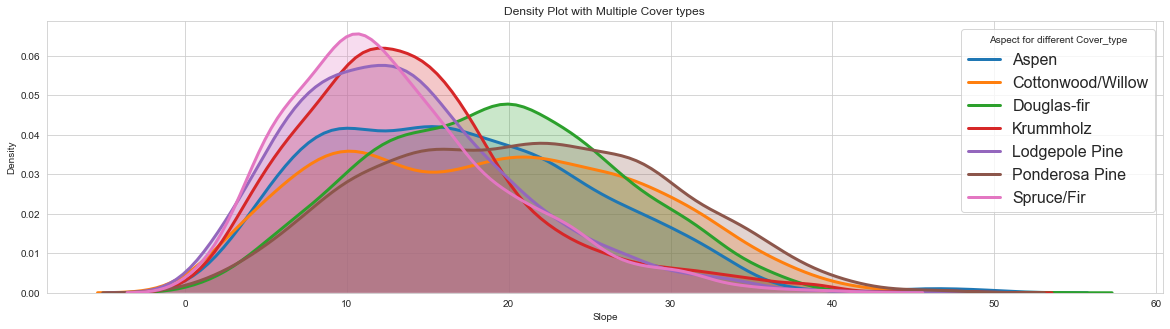

In [48]:
figure = plt.figure(figsize=(20,5))
cover_types = np.unique(forest['Cover_Type'].values)
for cover in cover_types:
    subset = forest[forest['Cover_Type'] == cover]
    
    sns.distplot(subset['Slope'], kde=True,hist=False,  label=cover, kde_kws = {'shade':True, 'linewidth': 3},)
    
plt.legend(prop={'size': 16}, title = 'Aspect for different Cover_type')
plt.title('Density Plot with Multiple Cover types')
plt.xlabel('Slope')
plt.ylabel('Density');

In [49]:
forest[['Cover_Type', 'Slope', 'Aspect']].groupby('Cover_Type').mean()

Slope      Aspect
Cover_Type                              
Aspen              16.754098  137.949883
Cottonwood/Willow  18.468519  138.099537
Douglas-fir        18.986111  180.617130
Krummholz          14.166667  155.794444
Lodgepole Pine     13.570201  150.847660
Ponderosa Pine     20.628704  173.672685
Spruce/Fir         13.170363  159.542237

### Aspect

According to the information found on the website, aspect identifies the direction of the downhill slope faces.

It is measured clockwise in degrees from 0 (due north) to 360 (again due north), coming full circle.

Flat areas having no downslope direction are given a value of -1.

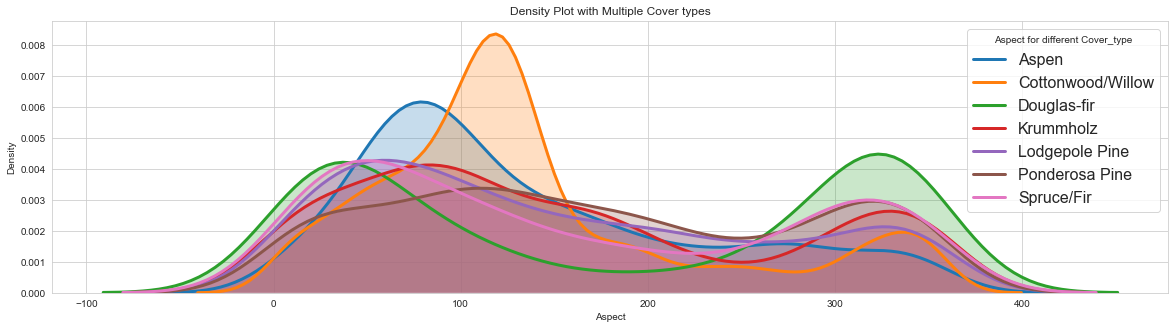

In [50]:
figure = plt.figure(figsize=(20,5))
cover_types = np.unique(forest['Cover_Type'].values)
for cover in cover_types:
    subset = forest[forest['Cover_Type'] == cover]
    
    sns.distplot(subset['Aspect'], kde=True,hist=False,  label=cover, kde_kws = {'shade':True, 'linewidth': 3},)
    
plt.legend(prop={'size': 16}, title = 'Aspect for different Cover_type')
plt.title('Density Plot with Multiple Cover types')
plt.xlabel('Aspect')
plt.ylabel('Density');


1. Douglas-fir, Spruce/Fir, Krummholz are found in Lower as well as higher Azimuths(Aspect)
2. Cottonwood/Willow and Aspen are found mostly at lower degree Azimuths and rarely at higher degree Azimuths.
3. Pondreosa is found at lower as well as at higher azimuths.

***Cover-Type has low correlation with Aspect ***

reference for directions:
https://www.mathsisfun.com/measure/compass-north-south-east-west.html 

### HD_Hydrology

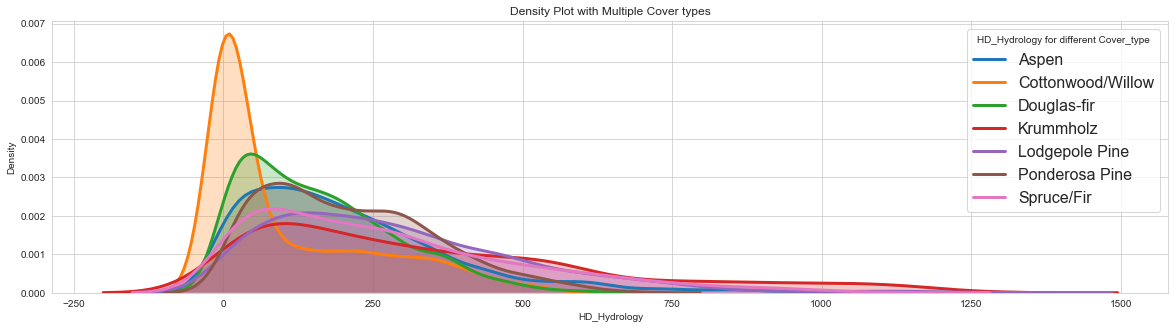

In [51]:
figure = plt.figure(figsize=(20,5))
cover_types = np.unique(forest['Cover_Type'].values)
for cover in cover_types:
    subset = forest[forest['Cover_Type'] == cover]
    
    sns.distplot(subset['HD_Hydrology'], kde=True,hist=False,  label=cover, kde_kws = {'shade':True, 'linewidth': 3},)
    
plt.legend(prop={'size': 16}, title = 'HD_Hydrology for different Cover_type')
plt.title('Density Plot with Multiple Cover types')
plt.xlabel('HD_Hydrology')
plt.ylabel('Density');

In [52]:
forest[['HD_Hydrology','Cover_Type']].groupby('Cover_Type').median()

HD_Hydrology
Cover_Type                     
Aspen                       175
Cottonwood/Willow            30
Douglas-fir                 134
Krummholz                   270
Lodgepole Pine              242
Ponderosa Pine              190
Spruce/Fir                  218

1. Cottonwood/Willow trees grow only in areas close to water. Also, since they grow at lower elevation, they are available    in low land areas.
2. Krummholz trees grow in rugged environments: cliffs, mountaintops(because of higher elevation), canyon walls and are        hence more distance to any surface water is possible.
3. Similarly , Lodgepole trees are commonly located near the ocean shore and in dry mountain forests.We can see many trees    near surface water , some far away.
4. Aspen trees generally grow in high-altitude areas. but also exists at sea level where climate conditions are ideal. most    of them are located near water surface.


### VD_Hydrology

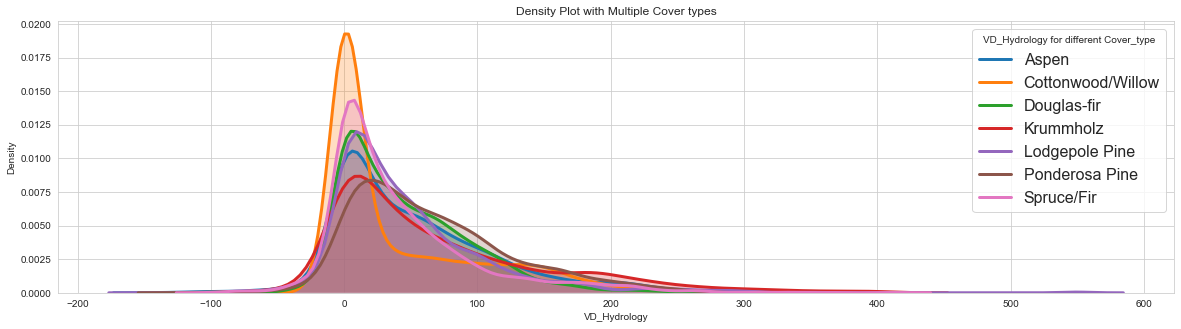

In [53]:
figure = plt.figure(figsize=(20,5))
cover_types = np.unique(forest['Cover_Type'].values)
for cover in cover_types:
    subset = forest[forest['Cover_Type'] == cover]
    
    sns.distplot(subset['VD_Hydrology'], kde=True,hist=False,  label=cover, kde_kws = {'shade':True, 'linewidth': 3},)
    
plt.legend(prop={'size': 16}, title = 'VD_Hydrology for different Cover_type')
plt.title('Density Plot with Multiple Cover types')
plt.xlabel('VD_Hydrology')
plt.ylabel('Density');

1. Here also , if we calculate average distance for Cottonwood tree to nearest surface water is the less compared to other    trees.
2. And Ponderosa and Krummholz vertical distance is more than the other trees.

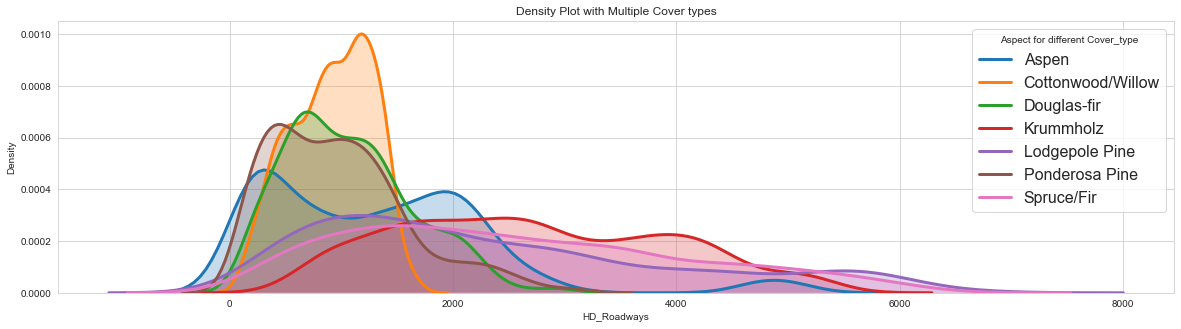

In [54]:
figure = plt.figure(figsize=(20,5))
cover_types = np.unique(forest['Cover_Type'].values)
for cover in cover_types:
    subset = forest[forest['Cover_Type'] == cover]
    
    sns.distplot(subset['HD_Roadways'], kde=True,hist=False,  label=cover, kde_kws = {'shade':True, 'linewidth': 3},)
    
plt.legend(prop={'size': 16}, title = 'Aspect for different Cover_type')
plt.title('Density Plot with Multiple Cover types')
plt.xlabel('HD_Roadways')
plt.ylabel('Density');

In [55]:
#code for printing 3d results

# fig = px.scatter_3d(forest, x='Hillshade_9am', y='Hillshade_Noon', z='Hillshade_3pm',
#               color='Cover_Type')
# fig.show()

### Hillshade_9am

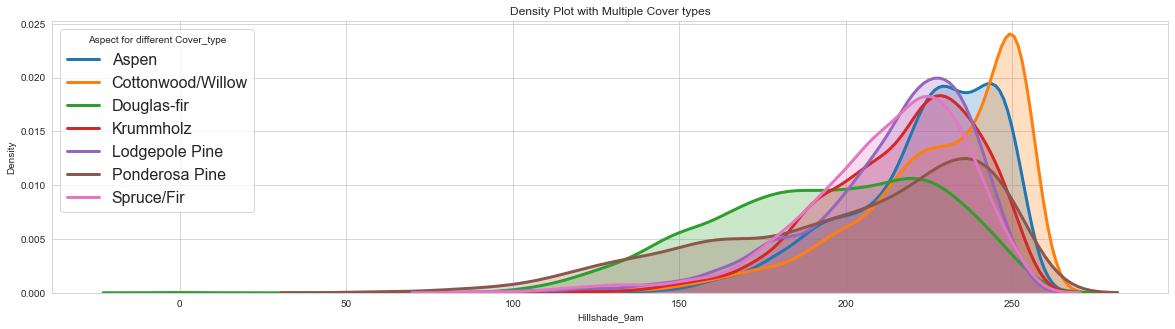

In [56]:
figure = plt.figure(figsize=(20,5))
cover_types = np.unique(forest['Cover_Type'].values)
for cover in cover_types:
    subset = forest[forest['Cover_Type'] == cover]
    
    sns.distplot(subset['Hillshade_9am'], kde=True,hist=False,  label=cover, kde_kws = {'shade':True, 'linewidth': 3},)
    
plt.legend(prop={'size': 16}, title = 'Aspect for different Cover_type')
plt.title('Density Plot with Multiple Cover types')
plt.xlabel('Hillshade_9am')
plt.ylabel('Density');

 Hillshade_9am shows left skew

### Hillshade_Noon

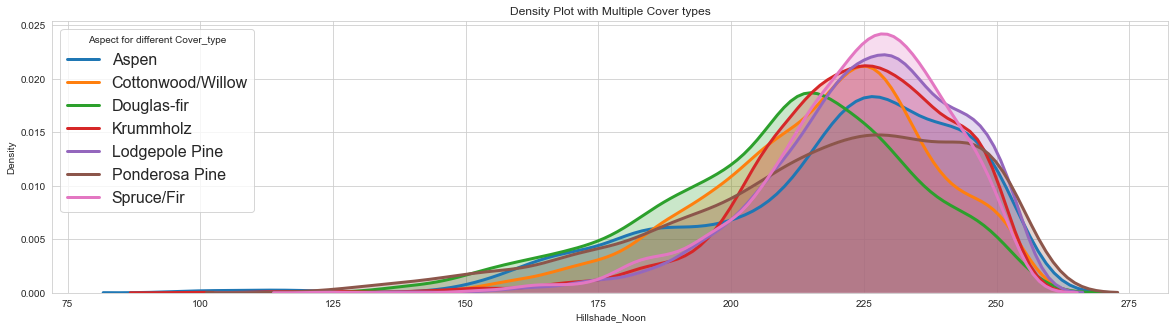

In [57]:
figure = plt.figure(figsize=(20,5))
cover_types = np.unique(forest['Cover_Type'].values)
for cover in cover_types:
    subset = forest[forest['Cover_Type'] == cover]
    
    sns.distplot(subset['Hillshade_Noon'], kde=True,hist=False,  label=cover, kde_kws = {'shade':True, 'linewidth': 3},)
    
plt.legend(prop={'size': 16}, title = 'Aspect for different Cover_type')
plt.title('Density Plot with Multiple Cover types')
plt.xlabel('Hillshade_Noon')
plt.ylabel('Density');

 Hillshade_Noon shows left skew

### Hillshade_3pm

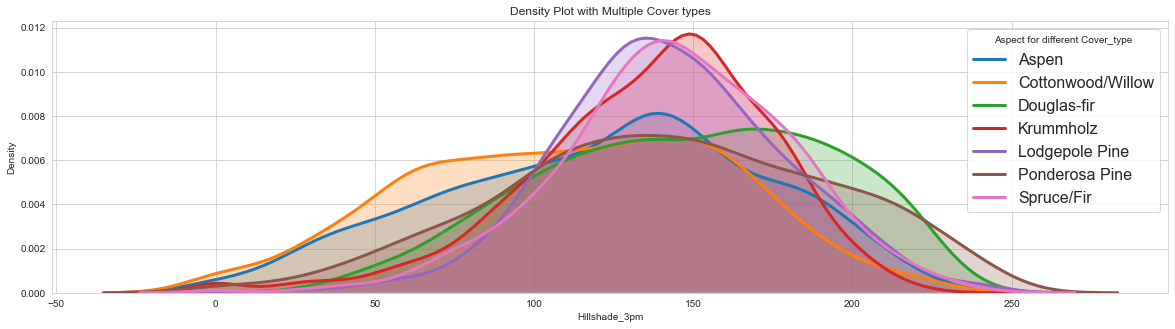

In [58]:
figure = plt.figure(figsize=(20,5))
cover_types = np.unique(forest['Cover_Type'].values)
for cover in cover_types:
    subset = forest[forest['Cover_Type'] == cover]
    
    sns.distplot(subset['Hillshade_3pm'], kde=True,hist=False,  label=cover, kde_kws = {'shade':True, 'linewidth': 3},)
    
plt.legend(prop={'size': 16}, title = 'Aspect for different Cover_type')
plt.title('Density Plot with Multiple Cover types')
plt.xlabel('Hillshade_3pm')
plt.ylabel('Density');

 Hillshade_3pm shows normal distribution

### Hillshade_Roadways

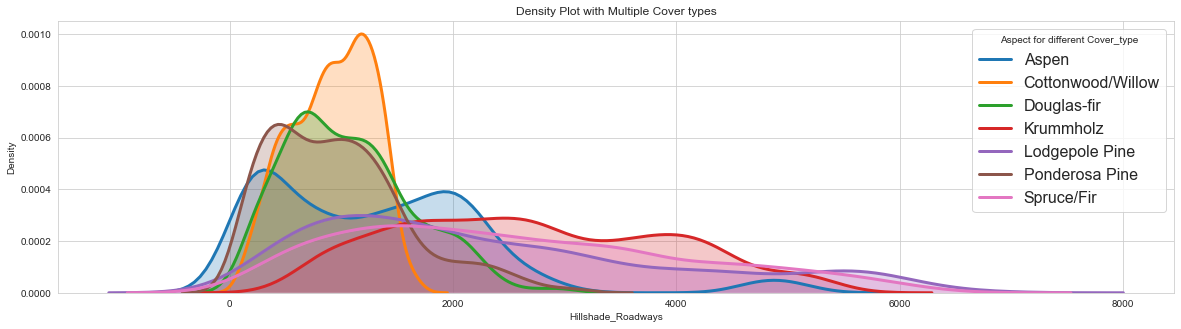

In [59]:
figure = plt.figure(figsize=(20,5))
cover_types = np.unique(forest['Cover_Type'].values)
for cover in cover_types:
    subset = forest[forest['Cover_Type'] == cover]
    
    sns.distplot(subset['HD_Roadways'], kde=True,hist=False,  label=cover, kde_kws = {'shade':True, 'linewidth': 3},)
    
plt.legend(prop={'size': 16}, title = 'Aspect for different Cover_type')
plt.title('Density Plot with Multiple Cover types')
plt.xlabel('Hillshade_Roadways')
plt.ylabel('Density');

1. Krummholz grow far away from roadways
2. Ponderosa , Cottonwood, Douglas/Fir grow near to Roadways.

### Wilderness_Area with respect to Cover_Type

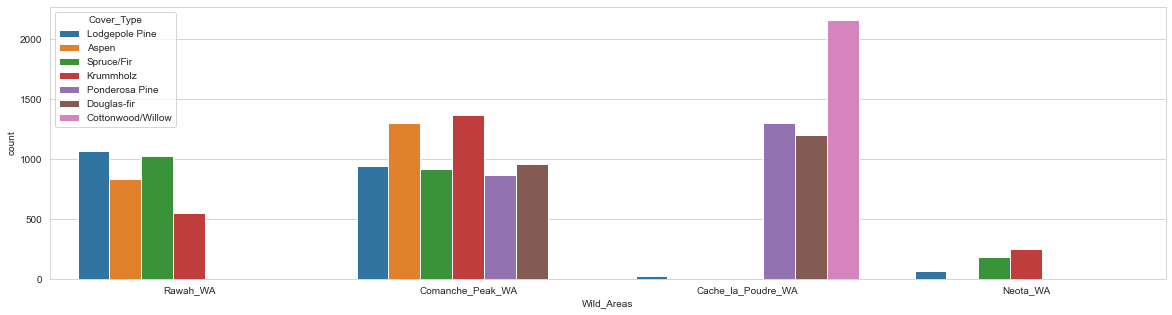

In [60]:
plt.figure(figsize=(20,5))
sns.countplot(x='Wild_Areas', hue='Cover_Type', data=forest);

In [61]:
forest[forest['Wild_Areas']=='Rawah_WA']['Cover_Type'].value_counts()

Lodgepole Pine    1068
Spruce/Fir        1021
Aspen              831
Krummholz          545
Name: Cover_Type, dtype: int64

1. Cache_la_poudre has higher Cottonwood/Willow trees.
2. Comanche_Peak_Wa has higher Aspen and Krummholz  trees
3. other wildareas cannot provide much distinction on CoverType

### Soil_Types with respect to Cover_Type

In [128]:
fig = px.histogram(forest, x='Soil_Types', color='Cover_Type', barmode='group', width=1200,height=500)
fig.show()

In [63]:
group = forest.groupby('Cover_Type',as_index=False)['Soil_Types']
    
for member in group:
    print(member[1]['Cover_Type'].max())
    print(member[1]['Soil_Types'].value_counts())
    print("-----")    
    

Aspen
ST30    469
ST13    305
ST29    243
ST23    157
ST11    154
ST17    131
ST4     129
ST33    115
ST32    100
ST31     87
ST10     64
ST2      61
ST18     42
ST26     28
ST19     18
ST24     11
ST16      8
ST20      6
ST34      4
ST28      3
Name: Soil_Types, dtype: int64
-----
Cottonwood/Willow
ST3     799
ST17    350
ST6     244
ST10    170
ST1     139
ST4     133
ST14    128
ST2      94
ST16     40
ST5      39
ST11     24
Name: Soil_Types, dtype: int64
-----
Douglas-fir
ST10    1101
ST2      182
ST6      151
ST1       95
ST17      88
ST4       87
ST5       71
ST11      67
ST33      66
ST13      66
ST14      37
ST16      37
ST20      37
ST32      30
ST3       18
ST24      15
ST31       7
ST23       3
ST34       2
Name: Soil_Types, dtype: int64
-----
Krummholz
ST38    641
ST39    575
ST40    407
ST35     98
ST29     76
ST23     72
ST32     70
ST33     67
ST37     34
ST24     31
ST31     27
ST30     20
ST22     16
ST36      8
ST4       7
ST21      4
ST34      4
ST27      3
Name: So

from graph and observation above :

* Aspen : ST30, ST13
* Cottonwood : ST3 , ST17
* Douglas/Fir  : ST10
* Krummholz : ST38, ST39,ST40
* Lodgepole Pine :ST29
* Ponderosa Pine : ST10 , ST4
* Spruce/Fir : ST29, ST23, ST200


## 2.2 Bivariate Analysis 

### HD_Hydrology  and VD_Hydrology

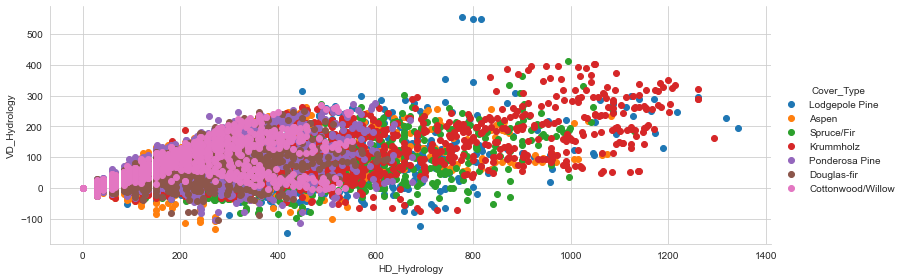

In [64]:
sns.FacetGrid(forest, hue='Cover_Type',height=4, aspect=2.75)\
    .map(plt.scatter, 'HD_Hydrology', 'VD_Hydrology')\
    .add_legend()

plt.show()

HD_Hydrology and HD_Hydrology looks positively correlated , hence onw can be eliminated while modeling.

## Soil Types in each wild Areas

In [65]:
for area in np.unique(forest['Wild_Areas']):
    fig = px.histogram(forest, x=forest[forest['Wild_Areas']==area]['Soil_Types'],
                 color=forest[forest['Wild_Areas']==area]['Cover_Type'],
                 barmode = 'group',height=400,width=1000, title= area)
    fig.show()


* Cache_la_Poudre Wild Area : Cottonwood/Willow, Douglas-fir, Ponderosa Pine trees are highly available 
* Comanche_Peak Wild Area : Krummholz, Ponderosa Pine , Douglas-Fir, Aspen are highly available
* Neota Wild Area : Krumholz is highly available.
* Rawah Wild Area : Lodgepole Pine, Spruce/Fir

### Soil Types in  each Wild Area

In [66]:
# ## code in Matplotlib ##
# plt.figure(figsize=(28,10))
# sns.countplot(x='Wild_Areas', hue='Soil_Types', data=forest, palette=sns.color_palette());
# plt.title('Soil Types Available in each Wild area',fontdict={'fontsize':20})
# plt.xlabel('Wild Areas',fontdict={'fontsize':15})
# plt.ylabel('Count',fontdict={'fontsize':15})
# plt.legend(loc='upper right', fontsize='x-large')
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16);

## code in plotly
px.histogram(forest, x='Wild_Areas',color='Soil_Types', barmode='group')

1. Rawah Wild Area is rich for ST29, ST30
2. Cache_la_Poudre Wild Area is rich for ST10, ST6, ST3
3. Comanche _Peak is diverse in Soil Types.
4. for Neota Wild Area less amount of information is available 

### Elevation for each Forest cover in each Wild Area  

In [67]:
temp = forest.groupby(['Wild_Areas','Cover_Type'],as_index=False)[['Elevation']].median()
fig = px.bar(temp, x="Wild_Areas", y="Elevation", color='Cover_Type', barmode='group',
             height=400,width=900)
fig.show()
temp.sort_values('Elevation', ascending=False).style.background_gradient(cmap='Reds')

1. Cover Type krummholz and Spruce/Fir only  grow at higher elevation in Neota, Comanche Peak and Rawah Wild Areas.
2. Cache_la_Poudre Wild Area is more in CoverType.
3. Cottonwood/Pillow grows at lower Elevations.

### Aspect for each Cover Type in each Wild Area 

In [68]:
temp = forest.groupby(['Wild_Areas','Cover_Type'],as_index=False)[['Aspect']].median()
fig = px.bar(temp, x="Wild_Areas", y="Aspect", color='Cover_Type', barmode='group',
             height=400,width=900)
fig.show()
temp.sort_values('Aspect', ascending=False).style.background_gradient(cmap='Reds')

1. Rawah Wild Area has Aspect in range 80-105.
2. Comanche_Peak Wild Area has aspect in range 150-170

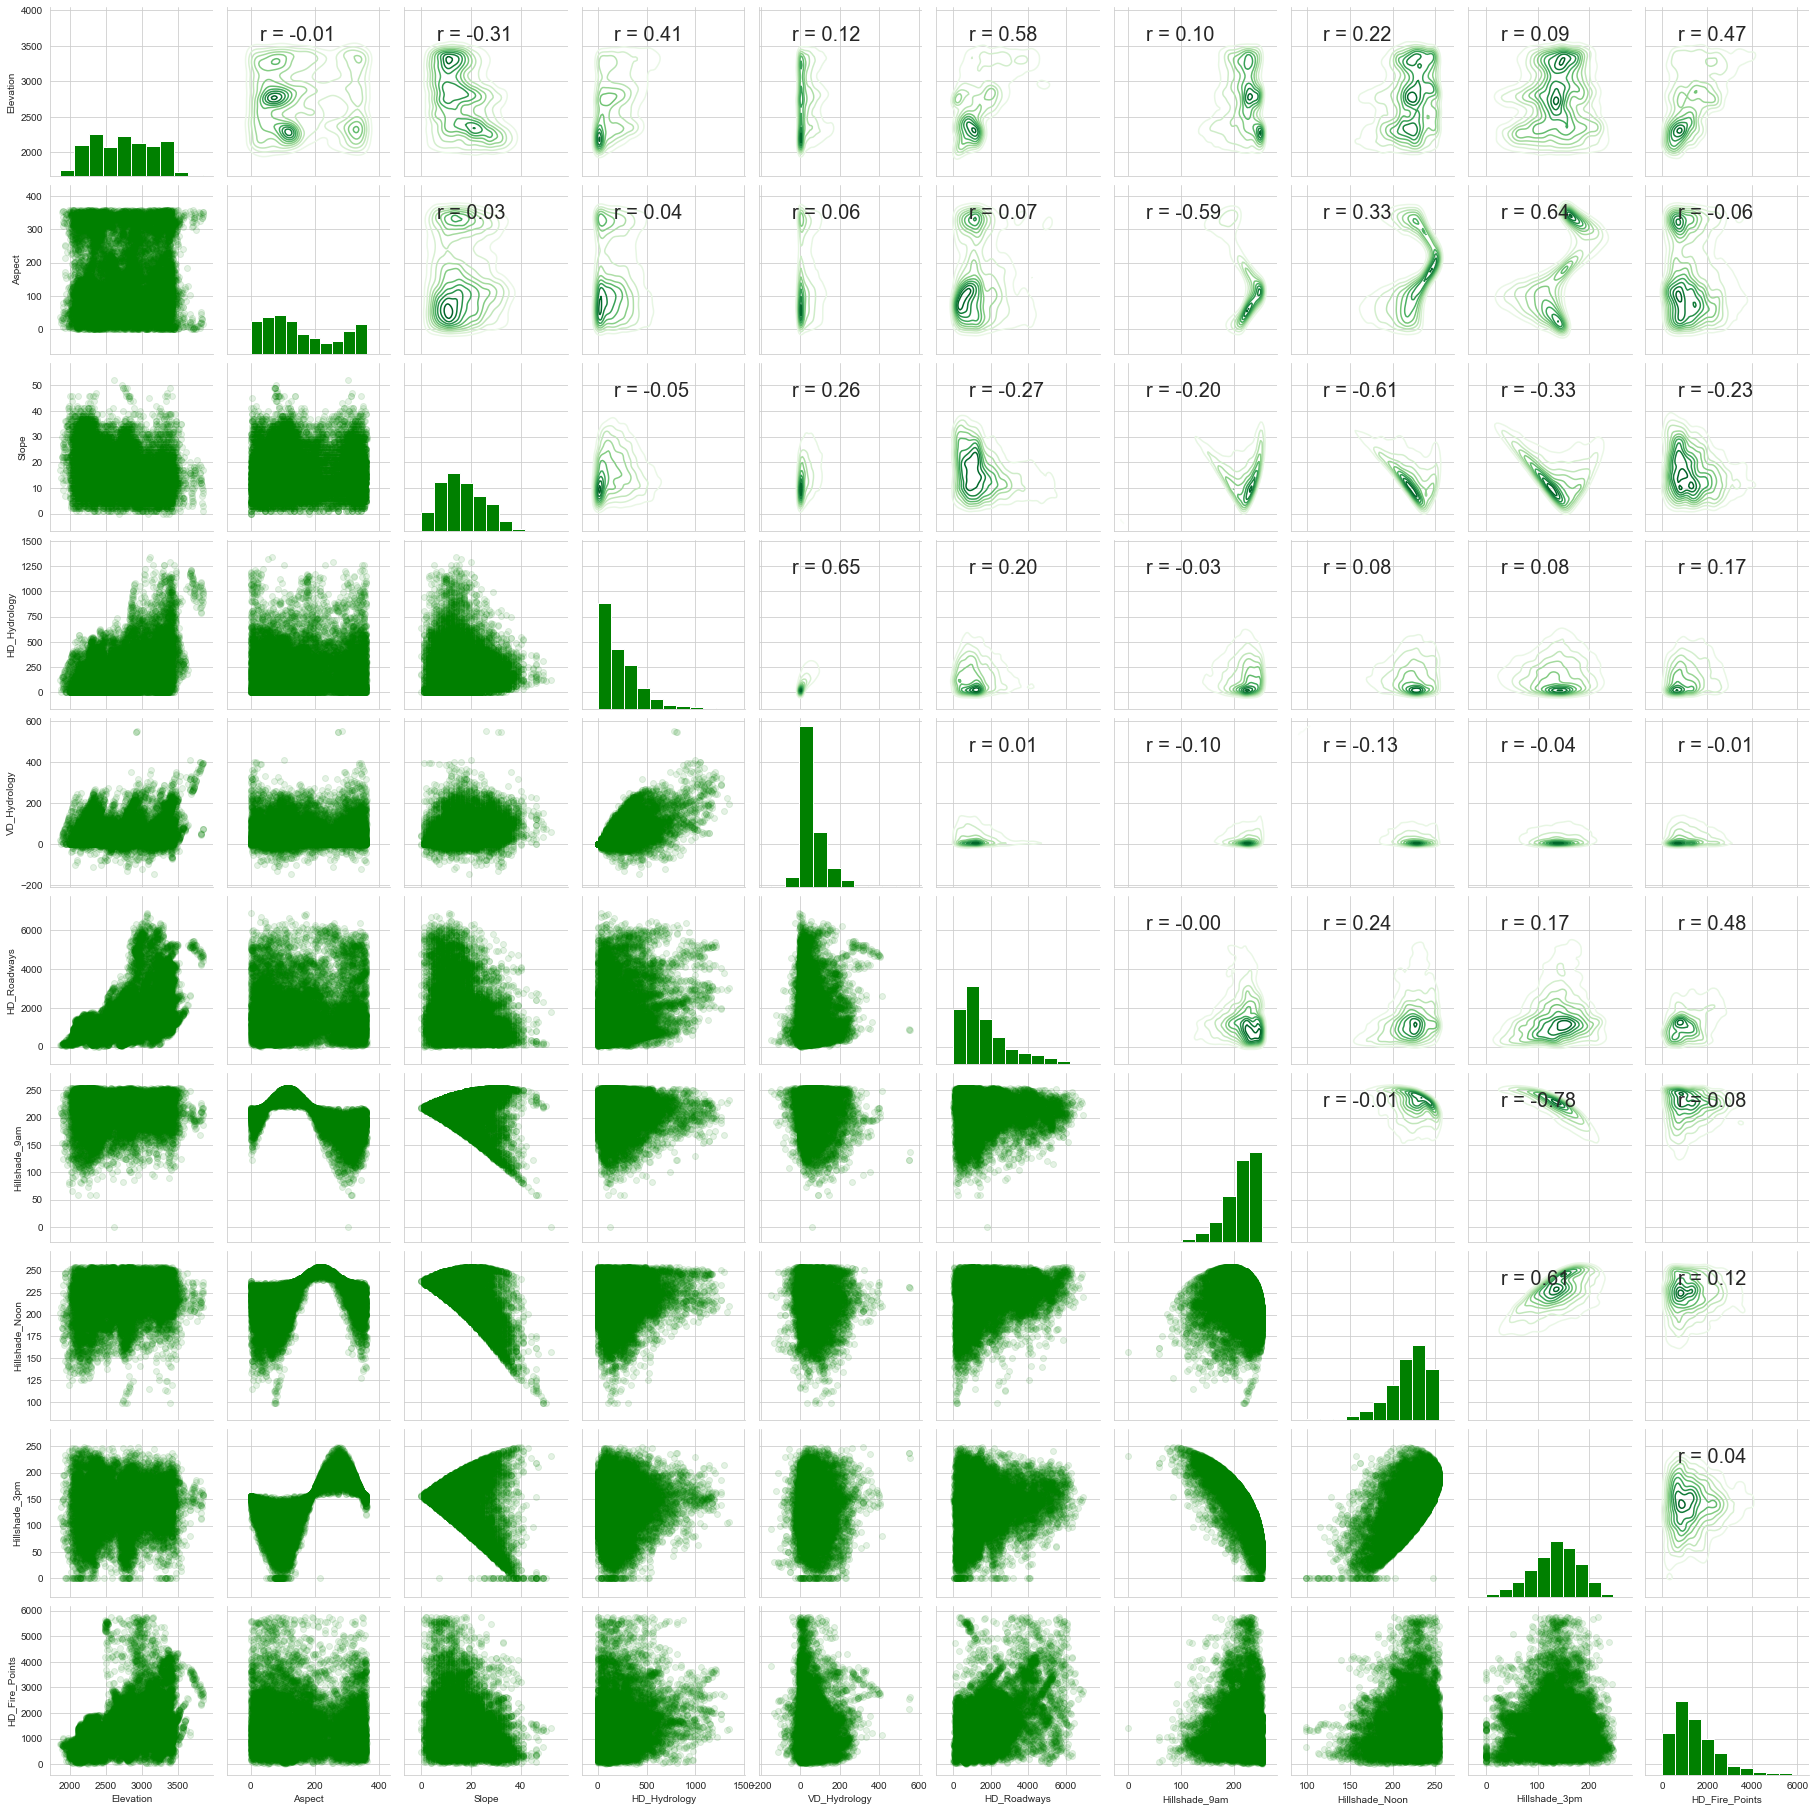

In [658]:
# store continious variables in a list
continuous_variables = forest.columns[:11].tolist()

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)
grid = sns.PairGrid(data = forest[continuous_variables])

# Upper is a correlation and kdeplot
grid.map_upper(corr_func);
grid.map_upper(sns.kdeplot, cmap = plt.cm.Greens)

# Diagonal is a histogram
grid.map_diag(plt.hist, color = 'green', edgecolor = 'white')

# Bottom is scatter plot
grid.map_lower(plt.scatter, color = 'green', alpha = 0.1)


1. VD_Hydrology and HD_Hydrology are positively correlated
2. hillshade9am and hillshade noon are positively correlated with hillshade_3pm
3. slope is negatively correlated with hillshade_noon
4. Aspect and Hillshade at 9am
5. Aspect and Hillshade at 3pm
6. Elevation and Horizontal Distance to Roadways.
 

### Removing out columns from data which do not provide information

In [69]:
# remove columns with Standard deviation =0 from original data set
col_name = []
for col in data.columns:
    if data[col].std()==0:
        col_name.append(col)
col_name        

['Soil_Type7', 'Soil_Type15']

we can remove these columns from original dataset

In [70]:
data = data.drop(['Soil_Type7', 'Soil_Type15'],axis=1)

# Observations from EDA

Data set have balanced labels, resulting in equal number of cover types. This will be an advantage when it comes to apply classification ML models because, the model will have good chance to learn patterns of all labels, eliminating the probability of underfitting.

Different wilderness areas consist of some specific trees. Interestingly, there is one fantastic tree, Cottonwood/Willow, specifically likes to grow in wilderness area 4. While cover types 1, 2, 5 and 6 can grow in any soil type, other cover types grows more with specific soil types.

Soil types are reverse-one-hot-encoded, meaning they are going to be included as numeric data in the training set and one-hot-encoded soil type columns will be excluded. With that way, there is a stronger correlation between soil type and Cover_Type. Numeric soil type column and other variables have pearson coefficients in the range of [-0.2, 0.1].

Hillshade columns are collinear within each other and Hillshade_9am has the least importance in determining Cover_Type. Thus this column will be dropped in Part 3 for better interpretability of the future model.

# 3. Training model with all features

### Converting the values Soil_Type column in to nominal values  

In [72]:
def split_nums_char(row):
    '''This function fetches the numerical characters at the end of a string
    and returns alphabetical character and numerical chaarcters respectively'''
    head = row.rstrip('0123456789') #rstrip() method returns a copy of the string in which all chars have been stripped from the end of the string
    tail = row[len(head):]
    return head, tail
    
tuple_Column = forest['Soil_Types'].apply(split_nums_char)   # example: ('ST',"3") 
number_column = tuple_Column.apply(lambda x : x[1])                
forest['Soil_Types'] = number_column.astype(int)
data['Soil_Types'] = forest['Soil_Types'].copy()

In [73]:
mapping = {'Spruce/Fir':1, 'Lodgepole Pine':2, 'Ponderosa Pine':3,
                              'Cottonwood/Willow':4, 'Aspen':5, 'Douglas-fir':6, 'Krummholz':7}
forest['Cover_Type'] = forest['Cover_Type'].map(mapping)
forest['Cover_Type'] = forest['Cover_Type'].astype(int)
data['Cover_Type'] = forest['Cover_Type'].copy()

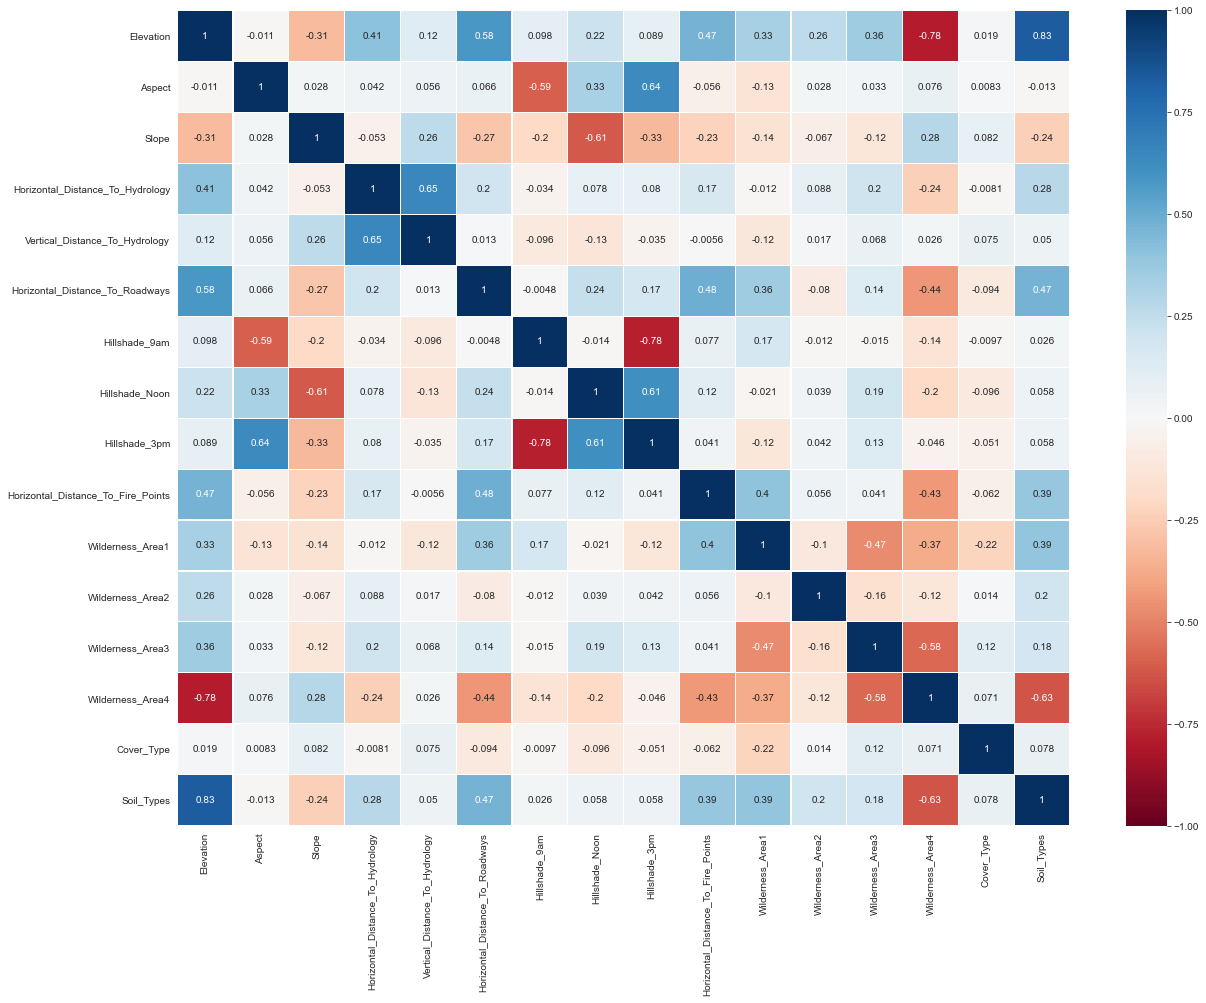

In [74]:
# temp_data = dataframe with Soil_Type column combined
temp_data = data.drop(columns=['Soil_Type1', 'Soil_Type2', 'Soil_Type3',
                               'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type8',
                               'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
                               'Soil_Type13', 'Soil_Type14', 'Soil_Type16','Soil_Type17', 
                                'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
                               'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
                               'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
                               'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
                               'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
                               'Soil_Type37', 'Soil_Type38', 'Soil_Type39','Soil_Type40'],axis=1)

data_corr = temp_data.corr()
plt.figure(figsize=(20,15))
sns.heatmap(data_corr, linewidths=0.1, cmap=plt.cm.RdBu,vmax=1.0, vmin=-1.0,annot=True);

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [129]:
features=['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4','Soil_Types']

In [130]:
X_train, X_valid, y_train, y_valid = train_test_split(data[features].values,data['Cover_Type'].values 
                                                      , test_size=0.2, random_state=1)
model = DecisionTreeClassifier()
model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [131]:
pred = model.predict(X_valid)
accuracy_score(y_valid, pred)

0.790527018012008

Hence accuracy improved with combined Soil Types

# 4. Feature Engineering and Selection

### 4.1. Add and Transform Features

In the data set, the strongest positive pearson coefficient is 0.22 and -0.11 on the other end. After doing some Google Search about the features, maybe adding some features might help achieving stronger correlations

I decided to add linear combinations of the horizontal distance columns and Euclidian distance of Horizontal_Distance_To_Hydrology and Vertical_Distance_To_Hydrology as suggested in this presentation.: https://www.slideshare.net/danielgribel/forest-cover-type-prediction-56288946?next_slideshow=2

***Elevation and Vertical Distance to Hydrology***

***Horizontal Distance to Hydrology and Horizontal Distance to Firepoints***

***Horizontal Distance to Hydrology and Horizontal Distance to Roadways***

***Horizontal Distance to Firepoints and Horizontal Distance to Roadways***

***Euclidian Distance of Horizontal Distance to Hydrology and Vertical Distance to Hydrology***

After the addition, I will perform square root transformation to the features with positive data range. Square root transformation might help especially for the highly skewed distributions.

After the addition and transformation, I will check pearson coefficients again.

In [90]:
# add columns
temp_data['Euclidian_Distance_To_Hydrology'] = np.sqrt(temp_data['Horizontal_Distance_To_Hydrology']**2 + temp_data['Vertical_Distance_To_Hydrology']**2)

temp_data['Mean_Elevation_Vertical_Distance_Hydrology'] = (temp_data['Elevation'] + temp_data['Vertical_Distance_To_Hydrology'])/2


temp_data['Mean_Elevation_Horizontal_Distance_Hydrology'] = (temp_data['Elevation'] + temp_data['Horizontal_Distance_To_Hydrology'])/2

temp_data['Mean_Distance_Hydrology_Firepoints'] = (temp_data['Horizontal_Distance_To_Hydrology'] + temp_data['Horizontal_Distance_To_Fire_Points'])/2

temp_data['Mean_Distance_Firepoints_Roadways'] = (temp_data['Horizontal_Distance_To_Fire_Points'] + temp_data['Horizontal_Distance_To_Roadways'])/2

temp_data['Mean_Distance_Hydrology_Roadways'] = (temp_data['Horizontal_Distance_To_Hydrology'] + temp_data['Horizontal_Distance_To_Roadways'])/2

In [91]:
# add sqrt transmormed columns
for col in temp_data.columns:
    if temp_data[col].min() >= 0:   # take square root only of positive values
        if col == 'Cover_Type':
            next
        else:
            temp_data['sqrt ' + col] = np.sqrt(temp_data[col])
            

In [92]:
correlations_transformed = temp_data.corr()
correlations_transformed = pd.DataFrame(correlations_transformed["Cover_Type"]).reset_index()
correlations_transformed = correlations_transformed.rename({'index': 'Feature'},axis=1)
correlations_transformed = correlations_transformed[correlations_transformed['Feature']!= 'Cover_Type'].sort_values(by='Cover_Type', ascending=True)

In [93]:
correlations_transformed

Feature  Cover_Type
31                              sqrt Wilderness_Area1   -0.220713
10                                   Wilderness_Area1   -0.220713
7                                      Hillshade_Noon   -0.095848
28                                sqrt Hillshade_Noon   -0.095399
5                     Horizontal_Distance_To_Roadways   -0.094212
20                  Mean_Distance_Firepoints_Roadways   -0.092875
21                   Mean_Distance_Hydrology_Roadways   -0.091495
40             sqrt Mean_Distance_Firepoints_Roadways   -0.089852
41              sqrt Mean_Distance_Hydrology_Roadways   -0.080075
26               sqrt Horizontal_Distance_To_Roadways   -0.076923
9                  Horizontal_Distance_To_Fire_Points   -0.062142
19                 Mean_Distance_Hydrology_Firepoints   -0.060509
29                                 sqrt Hillshade_3pm   -0.055879
39            sqrt Mean_Distance_Hydrology_Firepoints   -0.054423
30            sqrt Horizontal_Distance_To_Fire_Points   -0.052415
8                                       Hillshade_3pm   -0.051264
25              sqrt Horizontal_Distance_To_Hydrology   -0.031956
36               sqrt Euclidian_Distance_To_Hydrology   -0.027739
27                                 sqrt Hillshade_9am   -0.009947
6                                       Hillshade_9am   -0.009710
3                    Horizontal_Distance_To_Hydrology   -0.008078
16                    Euclidian_Distance_To_Hydrology   -0.003281
38  sqrt Mean_Elevation_Horizontal_Distance_Hydrology    0.001532
23                                        sqrt Aspect    0.002521
1                                              Aspect    0.008252
22                                     sqrt Elevation    0.010092
18       Mean_Elevation_Horizontal_Distance_Hydrology    0.011869
32                              sqrt Wilderness_Area2    0.013653
11                                   Wilderness_Area2    0.013653
37    sqrt Mean_Elevation_Vertical_Distance_Hydrology    0.019139
0                                           Elevation    0.019360
17         Mean_Elevation_Vertical_Distance_Hydrology    0.029451
35                                    sqrt Soil_Types    0.040500
34                              sqrt Wilderness_Area4    0.071171
13                                   Wilderness_Area4    0.071171
4                      Vertical_Distance_To_Hydrology    0.074566
15                                         Soil_Types    0.078027
2                                               Slope    0.081715
24                                         sqrt Slope    0.086921
33                              sqrt Wilderness_Area3    0.116628
12                                   Wilderness_Area3    0.116628

In [94]:
# adding trasnsformed featuers
data['sqrtHorizontal_Distance_To_Hydrology'] = temp_data['sqrt Horizontal_Distance_To_Hydrology']
data['sqrtSlope'] = temp_data['sqrt Slope']
data ['Mean_Distance_Firepoints_Roadways'] = temp_data['Mean_Distance_Firepoints_Roadways']
data['Mean_Distance_Hydrology_Roadways'] = temp_data['Mean_Distance_Hydrology_Roadways']
data['sqrtWilderness_Area1'] = temp_data['sqrt Wilderness_Area1']
data['Mean_Elevation_Vertical_Distance_Hydrology'] = temp_data['Mean_Elevation_Vertical_Distance_Hydrology']



# using F statistics to select best feature

In [95]:
from sklearn.feature_selection import f_classif


In [96]:
feat = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Types', 'sqrtHorizontal_Distance_To_Hydrology',
       'sqrtSlope', 'Mean_Distance_Firepoints_Roadways',
       'Mean_Distance_Hydrology_Roadways', 'sqrtWilderness_Area1',
       'Mean_Elevation_Vertical_Distance_Hydrology']
X_train, X_valid, y_train, y_valid = train_test_split(data[feat].values,
                                                      data['Cover_Type'].values 
                                                      , test_size=0.2, random_state=1)
# removed Soil_Types encoded variables 

In [97]:
[f_stat, f_pvalue] = f_classif(X_train, y_train)
f_test_df = pd.DataFrame({'feature_name':feat, 'F_static':f_stat,'p_value':f_pvalue})
f_test_df.sort_values('p_value')


feature_name      F_static        p_value
0                                    Elevation  13151.298179   0.000000e+00
18            Mean_Distance_Hydrology_Roadways   1105.881348   0.000000e+00
17           Mean_Distance_Firepoints_Roadways   1211.186742   0.000000e+00
15        sqrtHorizontal_Distance_To_Hydrology    371.457903   0.000000e+00
14                                  Soil_Types   5280.686287   0.000000e+00
13                            Wilderness_Area4   4022.536466   0.000000e+00
12                            Wilderness_Area3    367.325676   0.000000e+00
19                        sqrtWilderness_Area1    696.056425   0.000000e+00
9           Horizontal_Distance_To_Fire_Points    628.905718   0.000000e+00
10                            Wilderness_Area1    696.056425   0.000000e+00
6                                Hillshade_9am    307.657899   0.000000e+00
5              Horizontal_Distance_To_Roadways    963.897094   0.000000e+00
3             Horizontal_Distance_To_Hydrology    298.729460   0.000000e+00
20  Mean_Elevation_Vertical_Distance_Hydrology  10209.623058   0.000000e+00
2                                        Slope    238.130605  1.586310e-288
16                                   sqrtSlope    222.763826  1.254658e-270
8                                Hillshade_3pm    163.287338  3.301125e-200
11                            Wilderness_Area2    127.719369  3.274901e-157
7                               Hillshade_Noon     94.533065  1.690526e-116
4               Vertical_Distance_To_Hydrology     56.911815   1.076205e-69
1                                       Aspect     37.656057   1.555594e-45

In [98]:
from sklearn.feature_selection import SelectPercentile

In [99]:
selector = SelectPercentile(f_classif, percentile=40)

In [100]:
selector.fit(X_train, y_train)

SelectPercentile(percentile=40,
                 score_func=<function f_classif at 0x00000252817D78B8>)

In [101]:
best_features=[]
best_features = selector.get_support()
best_features

array([ True, False, False, False, False,  True, False, False, False,
       False,  True, False, False,  True,  True, False, False,  True,
        True, False,  True])

In [102]:
best_features = [ feat[counter] for counter in range(len(feat))  if best_features[counter] ]

In [103]:
best_features

['Elevation',
 'Horizontal_Distance_To_Roadways',
 'Wilderness_Area1',
 'Wilderness_Area4',
 'Soil_Types',
 'Mean_Distance_Firepoints_Roadways',
 'Mean_Distance_Hydrology_Roadways',
 'Mean_Elevation_Vertical_Distance_Hydrology']

# 5. Fitting model

## Fitting a Decison Tree with Best Features

In [104]:
X_train, X_valid, y_train, y_valid = train_test_split(data[best_features].values,
                                                      data['Cover_Type'].values 
                                                      , test_size=0.2, random_state=1)


In [106]:
DT_model = DecisionTreeClassifier(max_depth=11)
DT_model.fit(X_train,y_train)
pred = DT_model.predict(X_valid)
accuracy_score(y_valid, pred)

0.7651767845230153

# Fitting a Random Forest

In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [113]:
rf = RandomForestClassifier(n_estimators=100,criterion='gini', max_depth=None, min_samples_split=2,
                            min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
                            max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
                            bootstrap=True, oob_score=True, n_jobs=None,random_state=None,verbose=1,
                            warm_start=False,  max_samples=None)

In [114]:
rf_param = {'max_depth':[3, 6, 9, 12],
            'n_estimators':[10, 100,300,400,500,700,900]}

In [115]:
cv_rf = GridSearchCV(rf, param_grid=rf_param, scoring='accuracy', n_jobs=-1,
                 refit=True, cv=4,verbose=1, error_score=np.NaN,
                 return_train_score=True)

In [116]:
cv_rf.fit(X_train, y_train)

Fitting 4 folds for each of 28 candidates, totalling 112 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  4.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    5.1s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=True, random_state=None,
                                 

In [117]:
cv_rf_results = pd.DataFrame(cv_rf.cv_results_)
cv_rf_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.259283      0.045322         0.042481        0.019845   
1       1.605505      0.036285         0.179877        0.034224   
2       4.108776      0.071117         0.222000        0.051656   
3       5.069411      0.014947         0.380434        0.029415   
4       6.018514      0.142922         0.421968        0.060418   

  param_max_depth param_n_estimators                                 params  \
0               3                 10   {'max_depth': 3, 'n_estimators': 10}   
1               3                100  {'max_depth': 3, 'n_estimators': 100}   
2               3                300  {'max_depth': 3, 'n_estimators': 300}   
3               3                400  {'max_depth': 3, 'n_estimators': 400}   
4               3                500  {'max_depth': 3, 'n_estimators': 500}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0           0.614076           0.607071           0.626960           0.624625   
1           0.632088           0.608072           0.631965           0.634968   
2           0.630087           0.615410           0.628629           0.636637   
3           0.626418           0.614410           0.629963           0.628629   
4           0.630420           0.610073           0.633300           0.630964   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.618183        0.008045               28            0.606762   
1         0.626773        0.010864               24            0.635009   
2         0.627691        0.007705               23            0.631895   
3         0.624855        0.006162               27            0.631005   
4         0.626189        0.009367               25            0.631673   

   split1_train_score  split2_train_score  split3_train_score  \
0            0.636455            0.629267            0.622262   
1            0.632562            0.633159            0.629267   
2            0.637678            0.631158            0.628155   
3            0.637233            0.633604            0.624819   
4            0.634008            0.632381            0.626710   

   mean_train_score  std_train_score  
0          0.623686         0.010985  
1          0.632499         0.002073  
2          0.632221         0.003448  
3          0.631665         0.004529  
4          0.631193         0.002723

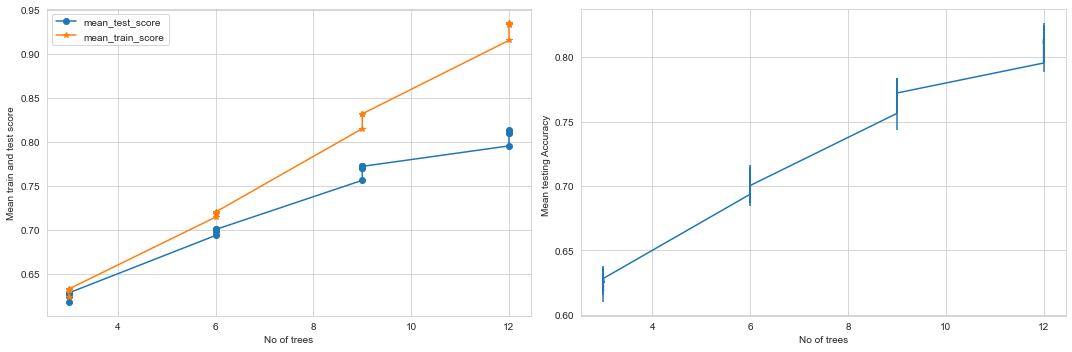

In [118]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axes[0].plot(cv_rf_results['param_max_depth'],
             cv_rf_results['mean_test_score'], '-o',label='mean_test_score')
axes[0].plot(cv_rf_results['param_max_depth'],
             cv_rf_results['mean_train_score'],'-*',label= 'mean_train_score')
axes[0].set_xlabel('No of trees')
axes[0].set_ylabel('Mean train and test score')
axes[0].legend()
axes[1].errorbar(cv_rf_results['param_max_depth'],
                cv_rf_results['mean_test_score'],
                yerr=cv_rf_results['std_test_score'])
axes[1].set_xlabel('No of trees')
axes[1].set_ylabel('Mean testing Accuracy  ')
plt.tight_layout()

In [119]:
cv_rf.best_params_

{'max_depth': 12, 'n_estimators': 300}

In [120]:
feat_imp_df = pd.DataFrame({'Feature_name':best_features,
                            'Importance':cv_rf.best_estimator_.feature_importances_})
feat_imp_df.sort_values(by='Importance', ascending=False)

Feature_name  Importance
0                                   Elevation    0.255378
4                                  Soil_Types    0.211394
7  Mean_Elevation_Vertical_Distance_Hydrology    0.178487
5           Mean_Distance_Firepoints_Roadways    0.114222
1             Horizontal_Distance_To_Roadways    0.093437
6            Mean_Distance_Hydrology_Roadways    0.084429
3                            Wilderness_Area4    0.038566
2                            Wilderness_Area1    0.024087

# 6. Visualisation of best model using Creating confusion matrix

In [121]:
from sklearn.metrics import confusion_matrix

In [122]:
# using random forest classifer with optimal parameters

rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=1, warm_start=False)

In [123]:
rf.max_depth =12
rf.n_estimators = 300
rf.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    4.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=1, warm_start=False)

In [124]:
y_predicted = rf.predict(X_valid)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.2s finished


In [125]:
# make a list of cover types
cover_types = np.unique(data['Cover_Type'])
cover_types

array([1, 2, 3, 4, 5, 6, 7])

In [126]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=True, title=None, cmap=plt.cm.Blues):
#      """
#         This function prints and plots the confusion matrix.
#         Normalization can be applied by setting `normalize=True`.
#       """
    if not title:
        if normalize:
            title = 'Normalize confusion Matrix'
        else:
            title = 'Confusion matrix without Normalization'
    
    # compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize == True:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis] # make it as column vector by inserting an axis along second dimension
        
    
    df_cm = pd.DataFrame(
        cm, index=classes, columns=classes, 
    )
    print(df_cm)
    fig = plt.figure(figsize=(10,8))
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=".2f",cmap=cmap)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, fontsize=12)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

    
    

          1         2         3         4         5         6         7
1  0.706731  0.158654  0.000000  0.000000  0.052885  0.000000  0.081731
2  0.235849  0.599057  0.014151  0.000000  0.117925  0.025943  0.007075
3  0.000000  0.002212  0.792035  0.064159  0.011062  0.130531  0.000000
4  0.000000  0.000000  0.047059  0.934118  0.000000  0.018824  0.000000
5  0.000000  0.018391  0.022989  0.000000  0.949425  0.009195  0.000000
6  0.000000  0.002375  0.137767  0.066508  0.038005  0.755344  0.000000
7  0.047059  0.000000  0.000000  0.000000  0.000000  0.000000  0.952941


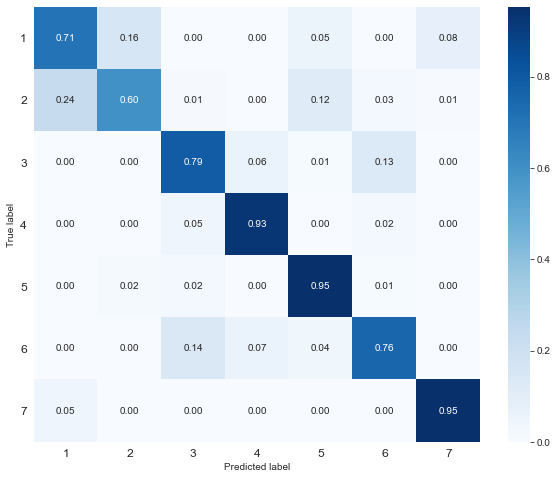

In [127]:
plot_confusion_matrix(y_valid, y_predicted, classes=cover_types, normalize=True)
plt.show()

In [134]:
accuracy_score(y_valid,y_predicted)

0.813542361574383

# 7. Interpret Model Results

## 7.1. Feature importances

Remember, in the exploratory data analysis I looked at the pearson coeffients of the features. Since final results are generated, I will revisit this picture and observe features with the highest contribution to the model predictions. feature_importances attribute will be used for this.

In [132]:
feat_imp_df = pd.DataFrame({'Feature_name':best_features,
                            'Importance':cv_rf.best_estimator_.feature_importances_})
feat_imp_df.sort_values(by='Importance', ascending=False)

Feature_name  Importance
0                                   Elevation    0.255378
4                                  Soil_Types    0.211394
7  Mean_Elevation_Vertical_Distance_Hydrology    0.178487
5           Mean_Distance_Firepoints_Roadways    0.114222
1             Horizontal_Distance_To_Roadways    0.093437
6            Mean_Distance_Hydrology_Roadways    0.084429
3                            Wilderness_Area4    0.038566
2                            Wilderness_Area1    0.024087

Random forests classification showed that:

* elevation
* soil type
* mean distance of elevation and vertical distance hydrology
* Mean_Distance_Firepoints_Roadways
* mean distance of horizontal distance to firepoints

are the most important characteristics of a fantastic tree.

# 8. Where to find these Trees ?

* Spruce/Fir, Lodgepole Pine and Krummholz loves to hangout in Rawah, Neota and Comanche Peak Wilderness Area which are Dry areas.

* Cache la Poudre Wilderness Area is perfect place for Ponderosa Pine and Cottonwood/Willow since these trees grow near watery surface.

* If you see an Aspen suspect that you might be at the Rawah or Comanche.

* Douglas-fir is an easy going species, that goes along with any wilderness area.